# Importing the libraries

In [26]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

In [27]:
device

device(type='cpu')

# 1. Utility function - to get the Image

In [28]:
def get_image(path,img_transform, size =(300,300)):  #300X300 we can change it if we want
  image = Image.open(path)
  image = image.resize(size, Image.LANCZOS)
  image = img_transform(image).unsqueeze(0)
  #transformations that ill be added to pytorch
  # Basically image dim: 3*H*W -> 1*3*H*W
  return image.to(device)

# 2. Utility function - to get the gram matrix

Consider two vectors(more specifically 2 **flattened feature vectors from a convolutional feature map of depth C**) representing features of the input space, and their **dot product** give us the information about the relation between them. The **lesser the product** the more different the learned features are and **greater the product** , the **more correlated** the features are.

Take all C feature vectors(flattened) from a convolutional feature map of depth C and compute the dot product with every one of them(including with a feature vector itself). The result is the Gram Matrix(of size CxC).



![GramMatrix](https://miro.medium.com/v2/resize:fit:518/format:webp/1*C3fkQanKHMwOi_rf0q0OQQ.png)

In [29]:
def get_gram(mat):
  _, c, h, w = mat.size() # getting batch-size, channels, height, width
  mat = mat.view(c, h * w) #two-dimensional matrix
  mat = torch.mm(mat, mat.t()) # multiplying matrix and its transpose
  return mat

# 3. Utility Function - Denormalized Image

After getting a pytorch tensor, we are de-normalizing it to a numpy array so that we can display it as a numpy image through matplotlib

In [30]:
def denormalized_img(tensor):
  inp = tensor.detach().cpu().squeeze() # squeezing it to remove singleton dimensions
  inp = inp.numpy().transpose((1,2,0)) #C,W,H -> H,W,C
  mean = np.array([0.485,0.456,0.406]) #some standard R,G,B values collected
  std = np.array([0.229,0.224,0.225])  #some standard R,G,B values collected
  inp = inp*std + mean
  inp = np.clip(inp,0,1) #valid pixel intensity range of [0, 1]
  return inp

## Feature Extractor Class
VGG19 is split into two portions:

- vgg19.features, which are all the convolutional and pooling layers
- vgg19.classifier, which are the three linear, classifier layers at the end


![Image](../work/image_NST.png)

In [31]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.selected_layers = [0,5,10,19,21] #List of layer indices from the VGG-16 architecture whose features are extracted
    # get the "features" portion of VGG19 (we will not need the "classifier" portion)
    self.vgg = models.vgg19(pretrained = True).features #Loading the VGG-19 model pretrained on ImageNet

  #Iterating through the layers of the VGG-16 model.
  def forward(self, x):
    layer_feats=[]
    for layer_num, layer in self.vgg._modules.items():
      x = layer(x) #Applying each layer to the input 
      if int(layer_num) in self.selected_layers:
        layer_feats.append(x)
    return layer_feats

# Taking the Image inputs and Doing the transformation 

In [32]:
img_transform= transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229,0.224,0.225))])
content_img = get_image('../work/content.jpg', img_transform)
style_img = get_image('../work/style.jpg',img_transform)
# generated_img = nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img = content_img.clone()
generated_img.requires_grad=True

optimizer = torch.optim.Adam([generated_img], lr =0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

# freezing the parameters
for p in encoder.parameters():
  p.requires_grad = False # or encoder.eval()

# Finally Computing the losses

- Content Loss = Average((content_features - generated_features) $^2$)
- Style Loss = Average((Gram Matrix of generated_features - Gram Matrix of style_features) $^2$) /(channel* height * width)

- Total Loss = Content_weight X Content Loss + Style_Weight X Style Loss

In [33]:
content_weight=1 # random weights - may try out a different one
style_weight =100 # random weights - may try out a different one
# Here we are not adding style weights to each style layer but rather one final style weight
for epoch in range(500):
  content_features = encoder(content_img)
  style_features = encoder(style_img)
  generated_features = encoder(generated_img)


  #calculating content_loss at the last layer
  content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)

  style_loss=0
  #calculating style_loss
  for gf,sf in zip(generated_features,style_features):
    _, c, h, w= gf.size()
    gram_gf = get_gram(gf)
    gram_sf = get_gram(sf)
    style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w) #normalizing the mean


  loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%10 ==0:
    print('Epoch [{}]\tContent Loss: {:.5f}\tStyle Loss: {:.5f}'.format(epoch, content_loss.item(),style_loss.item()))

Epoch [0]	Content Loss: 0.00000	Style Loss: 2497.29419
Epoch [10]	Content Loss: 1.95180	Style Loss: 2096.47168
Epoch [20]	Content Loss: 4.35648	Style Loss: 1633.10010
Epoch [30]	Content Loss: 5.82084	Style Loss: 1301.40076
Epoch [40]	Content Loss: 6.68593	Style Loss: 1098.45947
Epoch [50]	Content Loss: 7.31229	Style Loss: 950.15179
Epoch [60]	Content Loss: 7.82226	Style Loss: 831.86243
Epoch [70]	Content Loss: 8.24879	Style Loss: 735.46088
Epoch [80]	Content Loss: 8.59696	Style Loss: 655.88354
Epoch [90]	Content Loss: 8.87979	Style Loss: 589.67236
Epoch [100]	Content Loss: 9.11038	Style Loss: 533.94922
Epoch [110]	Content Loss: 9.29976	Style Loss: 486.58664
Epoch [120]	Content Loss: 9.46258	Style Loss: 445.94440
Epoch [130]	Content Loss: 9.60040	Style Loss: 410.72540
Epoch [140]	Content Loss: 9.72600	Style Loss: 380.08813
Epoch [150]	Content Loss: 9.84171	Style Loss: 353.24710
Epoch [160]	Content Loss: 9.94831	Style Loss: 329.53128
Epoch [170]	Content Loss: 10.04320	Style Loss: 308.456

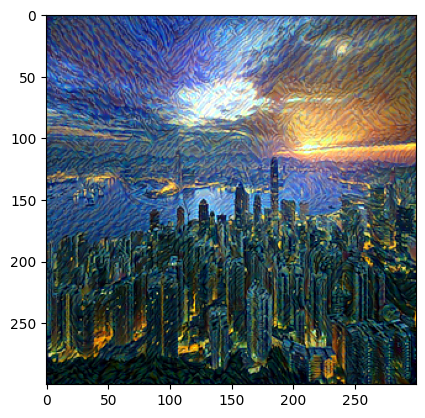

In [36]:
pic = denormalized_img(generated_img)
plt.imshow(pic)

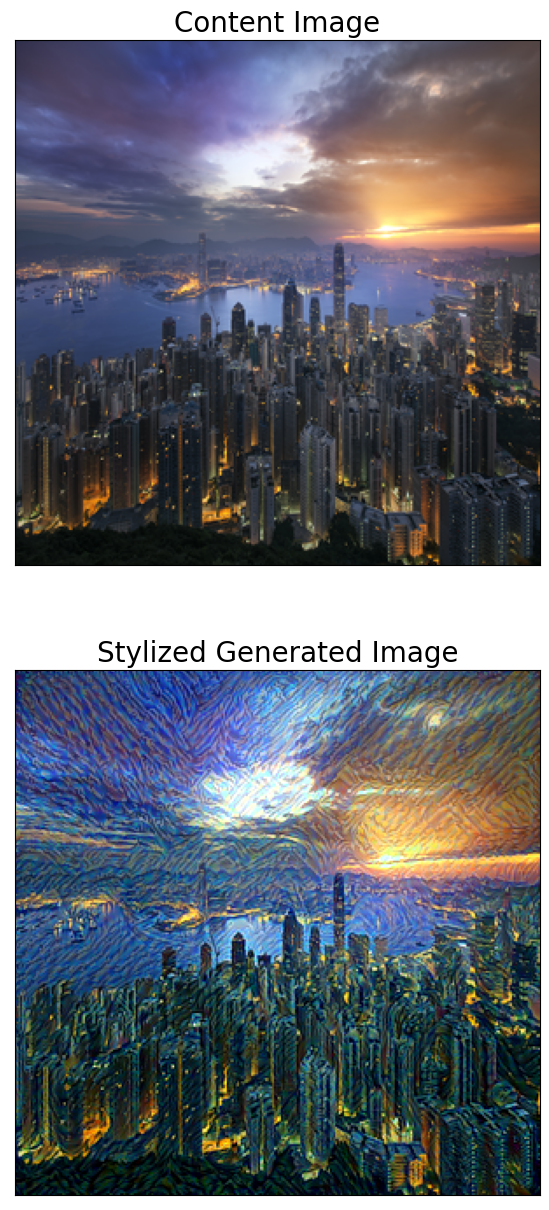

In [37]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(denormalized_img(content_img))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(denormalized_img(generated_img))
ax2.set_title("Stylized Generated Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()